In [1]:
# import the libraries
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

/home/joseph/miniconda3/envs/multimodal/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/joseph/miniconda3/envs/multimodal/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# visualization function
def show(tensor, ch=1, size=(28,28), num=16):
    # tensor : 128x784 (784:28x28)
    # for visualization, detach and move to cpu
    data = tensor.detach().cpu().view(-1,ch,*size) # 128x1x28x28
    grid = make_grid(data[:num], nrow=4).permute(1,2,0) # 1x28x28 -> 28x28x1
    plt.imshow(grid)
    plt.show()
    

In [3]:
# setup of the main parameters and hyperparameters
# step마다 batch처리
epochs = 500
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64 # dim of noise vector
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()
bs = 128 # batch size
device = 'cuda'

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()), shuffle=True, batch_size=bs) # shuffle for every epoch

# number of steps = 60000 / 128 = 468.75 : every epoch has 468.75 steps


In [4]:
# declare our models

# Generator
def genBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.BatchNorm1d(out),
        nn.ReLU(inplace=True) # decrease memory usage by not allocating extra memory
    )

class Generator(nn.Module):
    def __init__(self, z_dim=64, i_dim=784, h_dim=128):
    # input noise latent vector size, output image size, size of first hidden layer
        super().__init__()
        self.gen = nn.Sequential(
            genBlock(z_dim, h_dim), # 64 to 128
            genBlock(h_dim, h_dim*2), # 128 to 256  # increasing the output until we reach the final output of MNIST image size(784)
            genBlock(h_dim*2, h_dim*4), # 256 to 512
            genBlock(h_dim*4, h_dim*8), # 512 to 1024
            nn.Linear(h_dim*8, i_dim), # 1024 to 784(28x28)

            # we want the values of the pixels of the data of the image to be 0~1
            nn.Sigmoid()
        )
        
    def forward(self, noise):
        return self.gen(noise)
        
def gen_noise(number, z_dim): # generates noise
    return torch.randn(number, z_dim).to(device)


## Discriminator
def discBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.LeakyReLU(0.2)
    )
    
class Discriminator(nn.Module):
    def __init__(self, i_dim=784, h_dim=256):
        super().__init__()
        self.disc = nn.Sequential(
            discBlock(i_dim, h_dim*4), # 784 to 1024
            discBlock(h_dim*4, h_dim*2), # 1024 to 512
            discBlock(h_dim*2, h_dim), # 512 to 256
            # final output will be just one (real or fake)
            nn.Linear(h_dim, 1) # 256 to 1
        )
        
    def forward(self, image):
        return self.disc(image)

In [5]:
# Generator
gen = Generator(z_dim).to(device)
# Optimizer
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)


In [6]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [7]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([5, 0, 2, 0, 1, 6, 5, 4, 0, 3])


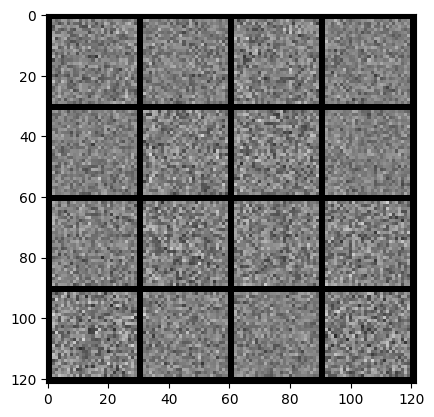

In [8]:
x, y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

noise = gen_noise(bs, z_dim)
fake = gen(noise)

show(fake) # initial output of passing the noise through the generator (pure random probabilistic noise)


In [10]:
# calculating the loss

# generator loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim): # gen:generator model, disc:discriminator model, number:num of elements we want to process, z_dim:dimensions of the input latent vector
    noise = gen_noise(number, z_dim)
    fake = gen(noise) # gen: Generator class instance
    pred = disc(fake)
    targets = torch.ones_like(pred) # vector of ones (means image is real)
    
    gen_loss = loss_func(pred,targets)
    
    return gen_loss
    
def calc_disc_loss(loss_func, gen, disc, number, real, z_dim): #real:need both fake/real images for discriminator
    
    # 1.fake images
    noise = gen_noise(number,z_dim)
    fake = gen(noise)
    disc_fake = disc(fake.detach()) #D의 loss 계산 및 optimize시에 G의 parameter들을 함께 변경하지 않기 위함
    disck_fake_targets = torch.zeros_like(disc_fake)
    disc_fake_loss = loss_func(disc_fake, disck_fake_targets)
    
    # 2.real images
    disc_real = disc(real)
    disc_real_targets = torch.ones_like(disc_real)
    disc_real_loss = loss_func(disc_real, disc_real_targets)
    
    # Final D loss (average of fake/real loss both)
    disc_loss = (disc_fake_loss+disc_real_loss)/2
    
    return disc_loss

In [ ]:
# number of steps = 60000 / 128 = 468.75 = 469: every epoch has 468.75 steps
# each step processes 128 images = size of the batch (except the last step)

for epoch in range(epochs):
    for real, _ in tqdm(dataloader): # real: MNIST images, _ (not using variable because this isn't supervised learning, instead it's generative adversarial learning)
        ### discriminator
        disc_opt.zero_grad()
        
        cur_bs = len(real) # 128x1x28x28 (last step smaller than 128)
        real = real.view(cur_bs,-1) # 128x784
        real = real.to(device)
        
        disc_loss = calc_disc_loss(loss_func,gen,disc,cur_bs,real,z_dim)
        
        
        disc_loss.backward(retain_graph = True)
        disc_opt.step()
        
        ### generator
        gen_opt.zero_grad()
        gen_loss = calc_gen_loss(loss_func,gen,disc,cur_bs,z_dim)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()
        
        ### visualization & stats
        mean_disc_loss += disc_loss.item() / info_step
        mean_gen_loss += gen_loss.item() / info_step
        
        if cur_step % info_step == 0 and cur_step>0: # not the beginning step, final
            fake_noise = gen_noise(cur_bs, z_dim)
            fake = gen(fake_noise)
            show(fake)
            show(real)
            print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss:{mean_disc_loss}")
            mean_gen_loss, mean_disc_loss = 0, 0 # to zero for new epoch step
        cur_step +=1
        

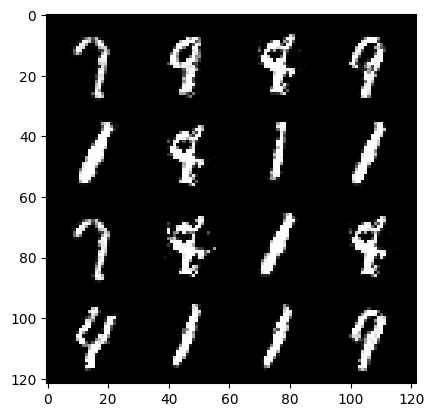

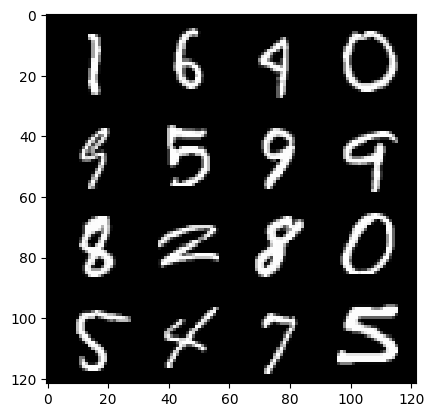

499: step 234500 / Gen loss: 1.490814339319866 / disc_loss:0.17949767986933388


In [13]:
fake_noise = gen_noise(cur_bs, z_dim)
fake = gen(fake_noise)
show(fake)
show(real)
print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss:{mean_disc_loss}")